Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [123]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [124]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [125]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [126]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [127]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [128]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [129]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [130]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

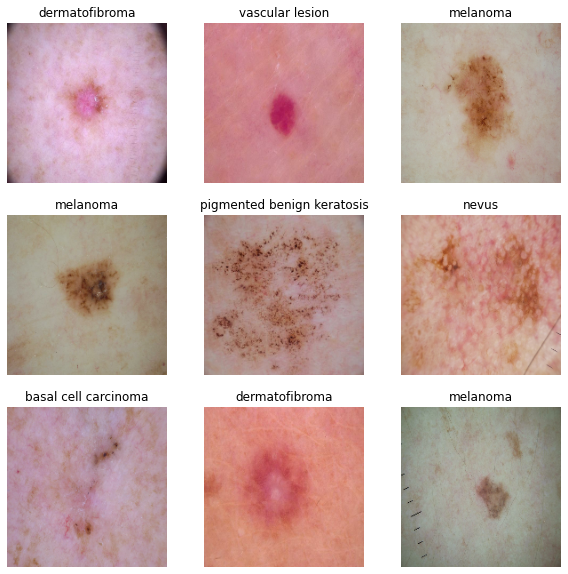

In [131]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for index in range(len(class_names)):
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(images[index].numpy().astype("uint8"))
    plt.title(class_names[labels[index]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [132]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [133]:
# ### Your code goes here

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [134]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer="adam",
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [135]:
# View the summary of all layers
# model.build(input_shape=(None, 180, 180, 3))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 45, 45, 64)      

### Train the model

In [136]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 49s 51ms/step - loss: 1.8975 - accuracy: 0.3069 - val_loss: 2.1630 - val_accuracy: 0.1739
Epoch 2/20
169/169 [==============================] - 8s 45ms/step - loss: 1.3484 - accuracy: 0.4963 - val_loss: 2.4043 - val_accuracy: 0.2174
Epoch 3/20
169/169 [==============================] - 7s 43ms/step - loss: 1.1371 - accuracy: 0.5862 - val_loss: 2.6081 - val_accuracy: 0.1739
Epoch 4/20
169/169 [==============================] - 7s 42ms/step - loss: 1.0122 - accuracy: 0.6322 - val_loss: 3.2872 - val_accuracy: 0.2174
Epoch 5/20
169/169 [==============================] - 7s 41ms/step - loss: 0.7702 - accuracy: 0.7220 - val_loss: 4.5626 - val_accuracy: 0.2609
Epoch 6/20
169/169 [==============================] - 7s 44ms/step - loss: 0.6340 - accuracy: 0.7795 - val_loss: 4.0743 - val_accuracy: 0.1304
Epoch 7/20
169/169 [==============================] - 7s 41ms/step - loss: 0.5015 - accuracy: 0.8255 - val_loss: 4.6103 - val_accuracy: 0.347

### Visualizing training results

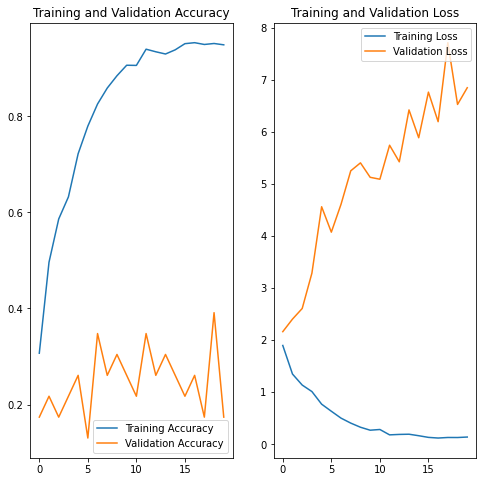

In [137]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> ### Observation
* we can observe that the model is performing really well on the training set but is performing poorly on the validation set.
* The loss for validation set just shot up while the same kept reducing for the validation set

### The model is most certainly overfitting on the train data

In [138]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip( "horizontal_and_vertical", input_shape=(img_height, img_width,3) ),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

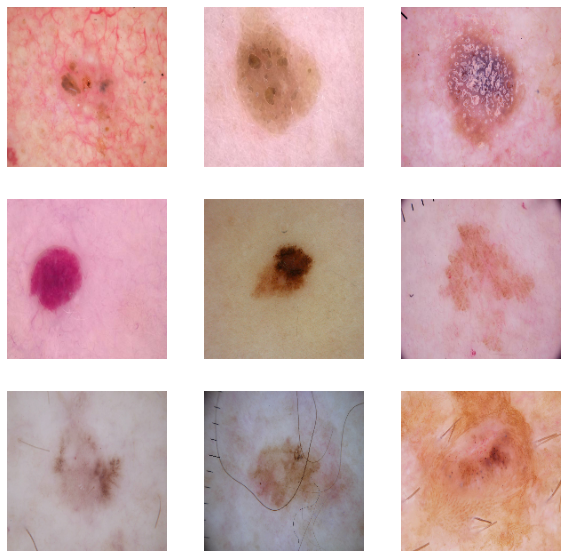

In [139]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for index in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(augmented_images[index].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [140]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(9)
])

### Compiling the model

In [141]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

### Training the model

In [142]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 11s 59ms/step - loss: 1.9115 - accuracy: 0.2769 - val_loss: 1.9599 - val_accuracy: 0.2609
Epoch 2/20
169/169 [==============================] - 10s 58ms/step - loss: 1.5462 - accuracy: 0.4104 - val_loss: 1.9656 - val_accuracy: 0.3043
Epoch 3/20
169/169 [==============================] - 10s 57ms/step - loss: 1.4530 - accuracy: 0.4477 - val_loss: 2.0858 - val_accuracy: 0.1739
Epoch 4/20
169/169 [==============================] - 10s 62ms/step - loss: 1.3995 - accuracy: 0.4666 - val_loss: 1.7700 - val_accuracy: 0.4348
Epoch 5/20
169/169 [==============================] - 9s 56ms/step - loss: 1.3728 - accuracy: 0.4701 - val_loss: 1.9361 - val_accuracy: 0.2174
Epoch 6/20
169/169 [==============================] - 9s 56ms/step - loss: 1.3518 - accuracy: 0.4774 - val_loss: 2.1948 - val_accuracy: 0.3043
Epoch 7/20
169/169 [==============================] - 9s 56ms/step - loss: 1.2953 - accuracy: 0.5022 - val_loss: 2.4086 - val_accuracy: 0.

### Visualizing the results

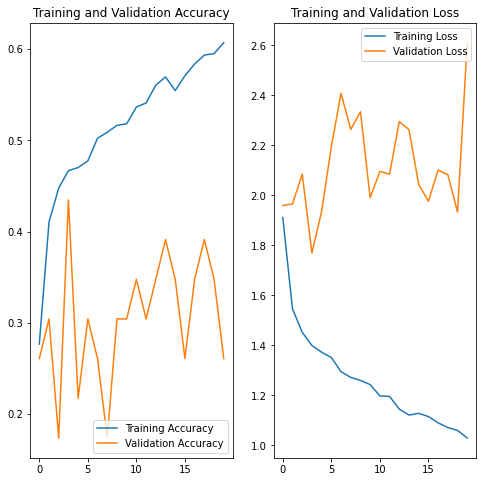

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We don't see much improvement in the model performance even after addition on agmentation layer, the model is still overfitting

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

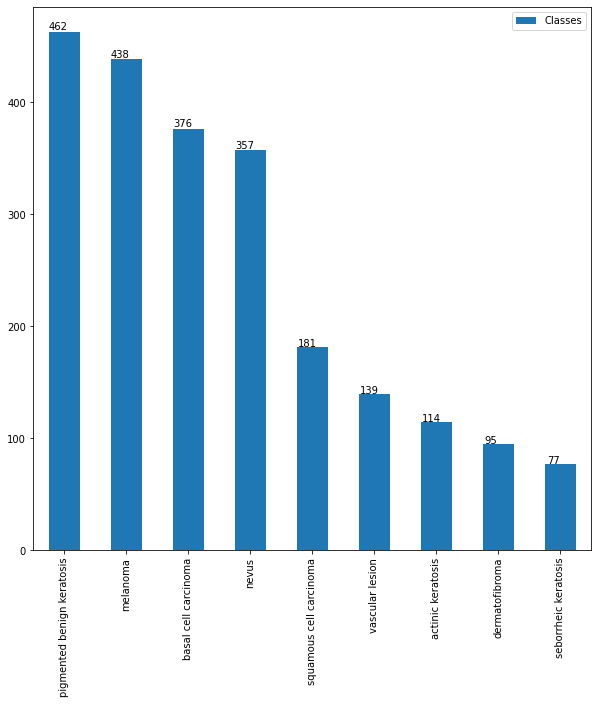

{'actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion'}

In [144]:
from IPython.core.pylabtools import figsize
## Your code goes here.

im_paths = [str(im_path) for im_path in list(data_dir_train.glob('*/*.jpg'))]
im_class = [path.split('/')[-2] for path in im_paths]
im_df=pd.DataFrame({"Image Paths":im_paths,"Classes":im_class})

figsize(10, 10)
ax = im_df.Classes.value_counts().to_frame().plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()
set(im_class)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
"seborrheic keratosis"
#### - Which classes dominate the data in terms proportionate number of samples?
"pigmented benign keratosis" & "melanoma"


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [145]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [146]:
path_to_training_dataset='/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F04A57769D0>: 100%|██████████| 500/500 [00:22<00:00, 22.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F04A7681790>: 100%|██████████| 500/500 [00:24<00:00, 20.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F04A59A2490>: 100%|██████████| 500/500 [00:24<00:00, 20.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F04A5797050>: 100%|██████████| 500/500 [01:35<00:00,  5.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F04A453CD90>: 100%|██████████| 500/500 [01:41<00:00,  4.92 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F04A5A80490>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F04A7028090>: 100%|██████████| 500/500 [00:47<00:00, 10.45 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F04A5A006D0>: 100%|██████████| 500/500 [00:21<00:00, 23.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F04A7028A90>: 100%|██████████| 500/500 [00:21<00:00, 23.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [147]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [149]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010007.jpg_83ddac17-b18a-4841-abbc-fa26756d26b1.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010413.jpg_72789517-4cb2-4e27-8b4f-d4158b2e89df.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000297.jpg_700fdd30-1882-403e-adc7-af6231fa6c45.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000441.jpg_163581a2-279a-4346-b382-d2150dac68cb.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000301.jpg_f149a43d-3de4-485d-86b9-1fd6449e1f6e.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International

In [150]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [153]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [156]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [157]:
new_df['Label'].value_counts()

melanoma                      1000
actinic keratosis             1000
vascular lesion               1000
basal cell carcinoma          1000
nevus                         1000
dermatofibroma                1000
squamous cell carcinoma       1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [158]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [160]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [161]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [162]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [163]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [165]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 28s 98ms/step - loss: 1.6835 - accuracy: 0.3541 - val_loss: 1.8439 - val_accuracy: 0.3262
Epoch 2/50
281/281 [==============================] - 15s 55ms/step - loss: 1.3984 - accuracy: 0.4484 - val_loss: 1.3373 - val_accuracy: 0.4802
Epoch 3/50
281/281 [==============================] - 15s 54ms/step - loss: 1.3005 - accuracy: 0.4908 - val_loss: 1.2435 - val_accuracy: 0.5162
Epoch 4/50
281/281 [==============================] - 15s 54ms/step - loss: 1.2357 - accuracy: 0.5191 - val_loss: 1.3256 - val_accuracy: 0.4976
Epoch 5/50
281/281 [==============================] - 15s 54ms/step - loss: 1.1758 - accuracy: 0.5377 - val_loss: 1.2073 - val_accuracy: 0.5327
Epoch 6/50
281/281 [==============================] - 15s 54ms/step - loss: 1.1121 - accuracy: 0.5633 - val_loss: 1.0825 - val_accuracy: 0.5754
Epoch 7/50
281/281 [==============================] - 15s 54ms/step - loss: 1.0454 - accuracy: 0.5859 - val_loss: 0.9905 - val_accuracy:

#### **Todo:**  Visualize the model results

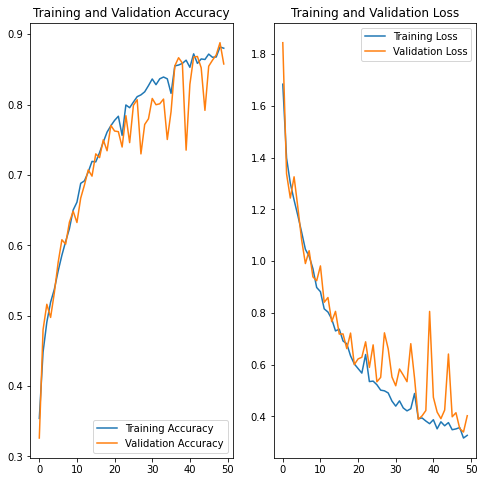

In [166]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



* The model has improved a lot
* The problem of overfitting has resolved to a great extent 
* Handling class imbalance improved the model as the probelm of overfitting is gone and the curves for validation as well as training are almost same